### Import Library

In [2]:
import cv2,matplotlib.pyplot as plt

### Import Model

In [3]:
from RAM_Analysis import RAM_Analysis
from movementDetector import movementDetectionModel
from randomForest import NoiseFilter

In [4]:
nf = NoiseFilter("merged_classification.csv")
nf.train()


Training Random Forest from scratch...
🌳 Training Tree [========================================>] 100%

In [6]:
md = movementDetectionModel(None)

In [7]:
def showDiff(frame0,frame1):
	diff_frame = md.draw_grid_difference(frame0,frame1,grid_size=10,threshold=80)
	minX,minY,maxX,maxY = md.box[0],md.box[1],md.box[2],md.box[3]
	pred,prob = nf.predict_box(minX,minY,maxX,maxY)
	label = "Noise" if pred == 0 else "Valid"
	color = (255,0,0) if pred == 0 else (0,255,0)
	result = cv2.rectangle(diff_frame,(minX,minY),(maxX,maxY),color,3)
	cv2.putText(result, f"Prediction: {label}", (md.box[0],md.box[1]-20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)
	print(f"label: {label}, Pred: {pred}, Prob: {prob}")
	plt.imshow(result)
	plt.axis('off')  # optional, remove axes
	plt.show()

label: Noise, Pred: 0, Prob: [0.98 0.02]


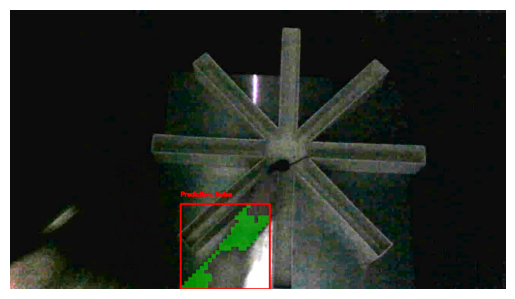

In [ ]:
videos_path = [
        r"E:\data datathon\drive-download-20250625T145832Z-1-004\B1_Hari 10.mp4",
        r"E:\data datathon\drive-download-20250625T145832Z-1-004\B3_Hari 10.mp4",
        r"E:\data datathon\drive-download-20250625T145832Z-1-004\C1_Hari 10.mp4",
        r"E:\data datathon\drive-download-20250625T145832Z-1-004\C4_Hari 10.mp4",
        r"C:\Users\zrota\Videos\A1_Hari 10.mp4"
        ]

frame0 = cv2.imread(r"testFrame\frame1.jpg")
frame1 = cv2.imread(r"testFrame\frame2.jpg")

showDiff(frame0,frame1)




In [ ]:
md = movementDetectionModel(r"E:\data datathon\drive-download-20250625T145832Z-1-004\C1_Hari 10.mp4")

for i in range(len(md.video)):
	print(i)
	plt.imshow(md.video[i])
	plt.axis('off')  # optional, remove axes
	plt.show()

: 

In [10]:
import os

FOLDER = "..\public\output"  # change to your folder
video_ext = ('.mp4', '.avi', '.mov', '.mkv')

video_paths = [
    os.path.join("output", f)

    for f in os.listdir(FOLDER)
    
    if f.lower().endswith(video_ext)
]

print(video_paths)


['output\\videoplayback.mp4']


In [20]:
import pandas as pd

# Baca CSV
df = pd.read_csv("merged_classification.csv")

# Pisahkan row label 0
df_label0 = df[df["label"] == 0]

# Buat salinan label 0 dan ubah label menjadi 1
df_label0_copy = df_label0.copy()
df_label0_copy["label"] = 1

# Gabungkan dengan dataframe asli
df_augmented = pd.concat([df, df_label0_copy], ignore_index=True)

# Optional: shuffle dataset agar acak
df_augmented = df_augmented.sample(frac=1, random_state=42).reset_index(drop=True)

# Simpan ke CSV baru
df_augmented.to_csv("merged_classification.csv", index=False)

print("Augmented dataset saved to 'merged_classification_augmented.csv'")
print(df_augmented["label"].value_counts())


Augmented dataset saved to 'merged_classification_augmented.csv'
label
1    1061
0     457
Name: count, dtype: int64


In [3]:
import pandas as pd
import numpy as np

# === CONFIG ===
INPUT_PATH = "merged_classification copy.csv"
OUTPUT_PATH = "merged_classification_spatial_augmented.csv"
DIST_THRESHOLD = 40  # pixels (30–50 is reasonable)

# === LOAD ===
df = pd.read_csv(INPUT_PATH)

# Compute centers
df["center_x"] = (df["min_x"] + df["max_x"]) / 2
df["center_y"] = (df["min_y"] + df["max_y"]) / 2

df_0 = df[df["label"] == 0].copy()
df_1 = df[df["label"] == 1].copy()

new_rows = []

# === SPATIAL AUGMENTATION ===
for _, row0 in df_0.iterrows():
    dx = df_1["center_x"].values - row0["center_x"]
    dy = df_1["center_y"].values - row0["center_y"]
    dist = np.sqrt(dx**2 + dy**2)

    if len(dist) > 0 and dist.min() <= DIST_THRESHOLD:
        new_row = row0.copy()
        new_row["label"] = 1
        new_rows.append(new_row)

# === MERGE ===
augmented_df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)

# Remove helper columns
augmented_df = augmented_df.drop(columns=["center_x", "center_y"])

# Save
augmented_df.to_csv(OUTPUT_PATH, index=False)

# Stats
print("Original:", df["label"].value_counts().to_dict())
print("Augmented:", augmented_df["label"].value_counts().to_dict())
print("Added positives:", len(new_rows))


Original: {1: 604, 0: 457}
Augmented: {1.0: 923, 0.0: 457}
Added positives: 319


In [25]:
import pandas as pd
import numpy as np

df = pd.read_csv("merged_classification copy.csv")

# IMPORTANT: make a copy
label1 = df[df["label"] == 1].copy()
label0 = df[df["label"] == 0].copy()


maxNum = len(label1)//4

def generateFeature(df_param):
	# Feature engineering
	df_param["width"] = df_param["max_x"] - df_param["min_x"]
	df_param["height"] = df_param["max_y"] - df_param["min_y"]
	df_param["area"] = df_param["width"] * df_param["height"]
	df_param["center_x"] = (df_param["min_x"] + df_param["max_x"]) / 2
	df_param["center_y"] = (df_param["min_y"] + df_param["max_y"]) / 2
	return df_param

def euclidDistance(x1,y1,x2,y2):
    dx = x2- x1
    dy = y2 - y1
    dist = np.sqrt(dx**2 + dy**2)
    return dist

label1 = generateFeature(label1)

label1["distance"] = euclidDistance(1,1,label1["center_x"],label1["center_y"])
maxdist = label1.sort_values(by="distance",ascending=False)["distance"].max()

label0 = generateFeature(label0)
label0["distance"] = euclidDistance(1,1,label0["center_x"],label0["center_y"])
distLabel0 = label0.sort_values(by="distance",ascending=False)
distLabel0[distLabel0["distance"] <= maxdist]


resultDf = pd.DataFrame()
distLabel0.loc[distLabel0["distance"] < maxdist, "label"] = 1
print(maxdist)
print(distLabel0)
print(distLabel0[distLabel0["label"] == 1])

df = pd.concat([df,distLabel0], ignore_index=True)
df = df[["min_x","min_y","max_x","max_y","frame","label"]]

df.to_csv("merged_classification.csv", index=False)


1081.9597959258929
     min_x  min_y  max_x  max_y  frame  label  width  height  area  center_x  \
67     950    630    960    640     97      0     10      10   100     955.0   
430    980    560   1000    590    251      0     20      30   600     990.0   
85    1070    370   1080    400    123      0     10      30   300    1075.0   
28     930    640    940    650     42      0     10      10   100     935.0   
353    890    600    970    680    127      0     80      80  6400     930.0   
..     ...    ...    ...    ...    ...    ...    ...     ...   ...       ...   
634    460    160    470    180    356      1     10      20   200     465.0   
139    420    160    460    260    206      1     40     100  4000     440.0   
296    420    230    430    240     26      1     10      10   100     425.0   
295    420    220    430    230     25      1     10      10   100     425.0   
100    330      0    350     10    152      1     20      10   200     340.0   

     center_y     di